In [1]:
import xarray as xr
import glob
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.linalg import eig
from scipy.stats import skew, skewtest, percentileofscore

import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors
import cmasher as cmr

import sys
sys.path.append("functions/")

import preprocessing
import experiment_settings
import build_model
import metricplots
import allthelinalg
import analysisplots
#import modelandmetrics

import importlib as imp

# pretty plots
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.sans-serif']=['Verdana']

params = {"ytick.color": "k",
          "xtick.color": "k",
          "axes.labelcolor": "k",
          "axes.edgecolor": "k"}
plt.rcParams.update(params)

In [19]:
imp.reload(preprocessing)
imp.reload(experiment_settings)
imp.reload(build_model)
imp.reload(metricplots)
imp.reload(allthelinalg)
imp.reload(analysisplots)

<module 'analysisplots' from '/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/functions/analysisplots.py'>

### Load all the experiment deets

In [3]:
modelpath = "models/"
experiment_name = "allcmodel-tos_allcmodel-tos_1-5yearlead"
experiment_dict = experiment_settings.get_experiment_settings(experiment_name)
filefront = experiment_dict["filename"]
filename = modelpath + experiment_dict["filename"]
modellist = experiment_dict["modellist"]
outbounds = experiment_dict["outbounds"]
trainvariants = experiment_dict["trainvariants"]
valvariants = experiment_dict["valvariants"]
testvariants = experiment_dict["testvariants"]
seedlist = experiment_dict["seeds"]
run = experiment_dict["run"]
leadtime = experiment_dict["leadtime"]
year1 = 1851+run

lon, lat = preprocessing.outlonxlat(experiment_dict)
lon = np.asarray(lon)
lat = np.asarray(lat)
centre = (outbounds[2]+outbounds[3])/2
projection = ccrs.EqualEarth(central_longitude=centre)
inres = experiment_dict["inres"]
transform = ccrs.PlateCarree()
obsyearvec = np.arange(1870+2*run+leadtime,2023,)
modelyearvec = np.arange(year1+2*run+leadtime,2015)

### Also load in the preprocessed data

In [48]:
datafile = "processed_data/" + filefront + ".npz"

datamat = np.load(datafile)

allinputdata = datamat["allinputdata"]
alloutputdata = datamat["alloutputdata"]

trainvaltest = [trainvariants,valvariants,testvariants]

inputdata,inputval,inputtest,outputdata,outputval,outputtest = preprocessing.splitandflatten(
    allinputdata,alloutputdata,trainvaltest,experiment_dict["run"])

inputdata[:, np.isnan(np.mean(inputdata, axis=0))] = 0
inputval[:, np.isnan(np.mean(inputval, axis=0))] = 0
inputtest[:, np.isnan(np.mean(inputtest, axis=0))] = 0

outputstd = np.std(outputdata, axis=0, keepdims=True)
outputdata = outputdata/outputstd
outputval = outputval/outputstd
outputtest = outputtest/outputstd

outputdata[:, np.isnan(np.mean(outputdata, axis=0))] = 0
outputval[:, np.isnan(np.mean(outputval, axis=0))] = 0
outputtest[:, np.isnan(np.mean(outputtest, axis=0))] = 0  

nvars = int(len(valvariants)*len(modellist))
nvariant = len(testvariants)
nmodels = len(modellist)
ntimesteps = int(len(outputtest)/(nvariant*nmodels))
n1model = ntimesteps*nvariant

mask = np.copy(outputtest)
mask[mask==0] = np.nan
landmask = ~np.isnan(np.mean(mask,axis=0))

conversion done


### Also also load in obs

In [5]:
inputobs_ERSST,outputobs_ERSST = preprocessing.make_inputoutput_obs(experiment_dict,"ERSST")
inputobs_ERSST,outputobs_ERSST = preprocessing.concatobs(inputobs_ERSST,outputobs_ERSST,outputstd,run)

inputobs_HadISST,outputobs_HadISST = preprocessing.make_inputoutput_obs(experiment_dict,"HadISST")
inputobs_HadISST,outputobs_HadISST = preprocessing.concatobs(inputobs_HadISST,outputobs_HadISST,outputstd,run)

/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/data/HadISST_sst_2x2.nc
/Users/egordon4/Documents/Experiments/NPac_MultiYear_SkillComponentAnalysis/data/HadISST_sst_2x2.nc


### Calculate the PDO in each model individually and also across all models
Or just load it in if I've already calculated and saved it

In [6]:
PDOfile = "processed_data/" + "PDO_" + filefront + ".npz"
saveflag = False

if saveflag:
    PDOpatterns_singlemodel = preprocessing.PDO_pattern_singlemodel(experiment_dict)
    PDOpattern_allmodel = preprocessing.PDO_pattern_allmodels(experiment_dict)
    
    np.savez(PDOfile,
              PDOpatterns_singlemodel=PDOpatterns_singlemodel,
              PDOpattern_allmodel=PDOpattern_allmodel,
              )
else:
    
    PDOmat = np.load(PDOfile)
    PDOpatterns_singlemodel = PDOmat["PDOpatterns_singlemodel"]
    PDOpattern_allmodel = PDOmat["PDOpattern_allmodel"]
    

### Some useful analysis functions to have here and not in an external file whatever

In [7]:
def reshapengrab(inputmatrix,ind,nmodels,nvariants):

    # grabs all variants (nvariant) for a single climate model data (ind of nmodel) 
    inputshape = inputmatrix.shape
    ntimesteps = int(inputshape[0]/(nmodels*nvariants))
    if len(inputshape) == 3:        
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2]))
    else:
        intmatrix = np.reshape(inputmatrix,(nmodels,nvariants,ntimesteps,inputshape[1],inputshape[2],inputshape[3]))
    
    outputint = intmatrix[ind]
    if len(inputshape) == 3:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2])
    else:
        shapeout = (ntimesteps*nvariants,inputshape[1],inputshape[2],inputshape[3])
    outputmatrix = np.reshape(outputint,shapeout)    
    
    return outputmatrix

def model_member_corr(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):
    
    modelpearsons = np.empty((nmodels,nvariant))
    modelps = np.empty((nmodels,nvariant))
    
    #modelpearsonsall = np.empty((nmodels))

    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelpearsons[imodel,imem],modelps[imodel,imem] = allthelinalg.corr_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelpearsons

def model_member_err(pattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask):

    modelerrs = np.empty((nmodels,nvariant))
    patterndims = len(pattern.shape)
    
    for imodel in range(nmodels):
             
        outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
        y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
        if patterndims == 2:            
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern,outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
        
        elif patterndims == 3:
            for imem in range(nvariant):
                outputtest_singlemem = outputtestloop[ntimesteps*imem:ntimesteps*(imem+1)]
                y_pred_test_singlemem = y_pred_testloop[ntimesteps*imem:ntimesteps*(imem+1)]
        
                modelerrs[imodel,imem] = allthelinalg.err_indextimeseries(
                    pattern[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,landmask)
    
    return modelerrs
    

### Load in each trained CNN
Load in the CNNs and predict the validation data and then perform SCA on the output timeseries.
Here we calculate the first skill component, **q** from the validation data with **q** defined as

$$ \Sigma_E \mathbf q = \lambda \Sigma_V \mathbf q$$

Where $\Sigma_E$ is the error covariance matrix, and $\Sigma_V$ is the verification covariance (in this case, the covariance of the validation data). Here, we grab the first skill component, i.e., the component that corresponds to the lowest $\lambda$.

336/336 [==============================] - 1s 4ms/step


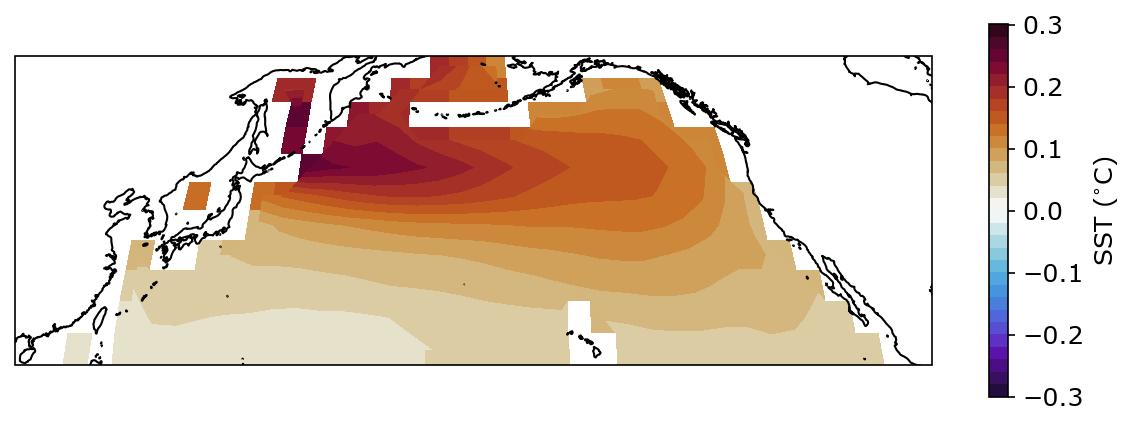

In [32]:
imp.reload(analysisplots)
for random_seed in seedlist[:1]:

    fileout = filename + "_seed=" + str(random_seed) +".h5"

    tf.random.set_seed(random_seed)
    np.random.seed(random_seed) 
    
    full_model = build_model.build_CNN_full(inputdata, outputdata, 
                                                    experiment_dict, random_seed)  
    
    full_model.compile(optimizer=tf.keras.optimizers.legacy.SGD(experiment_dict["learning_rate"]),  # optimizer
                        loss=tf.keras.losses.MeanSquaredError(), 
                      )

    full_model.load_weights(fileout)
    
    full_model.trainable = False # freeze BN
    
    y_pred_test = full_model.predict(inputtest)
    y_pred_val = full_model.predict(inputval) 

    bestpattern = allthelinalg.calculate_SC(y_pred_val,outputval,landmask)   

    analysisplots.plotpattern_SST(bestpattern,lon,lat,outputstd)

### Now examine SCA on obs

Take the pattern calculated from the validation data above and project it onto obs, and also the testing members from the GCMs.

5/5 [==============================] - 0s 5ms/step
np conversion done
eof done
np conversion done
eof done


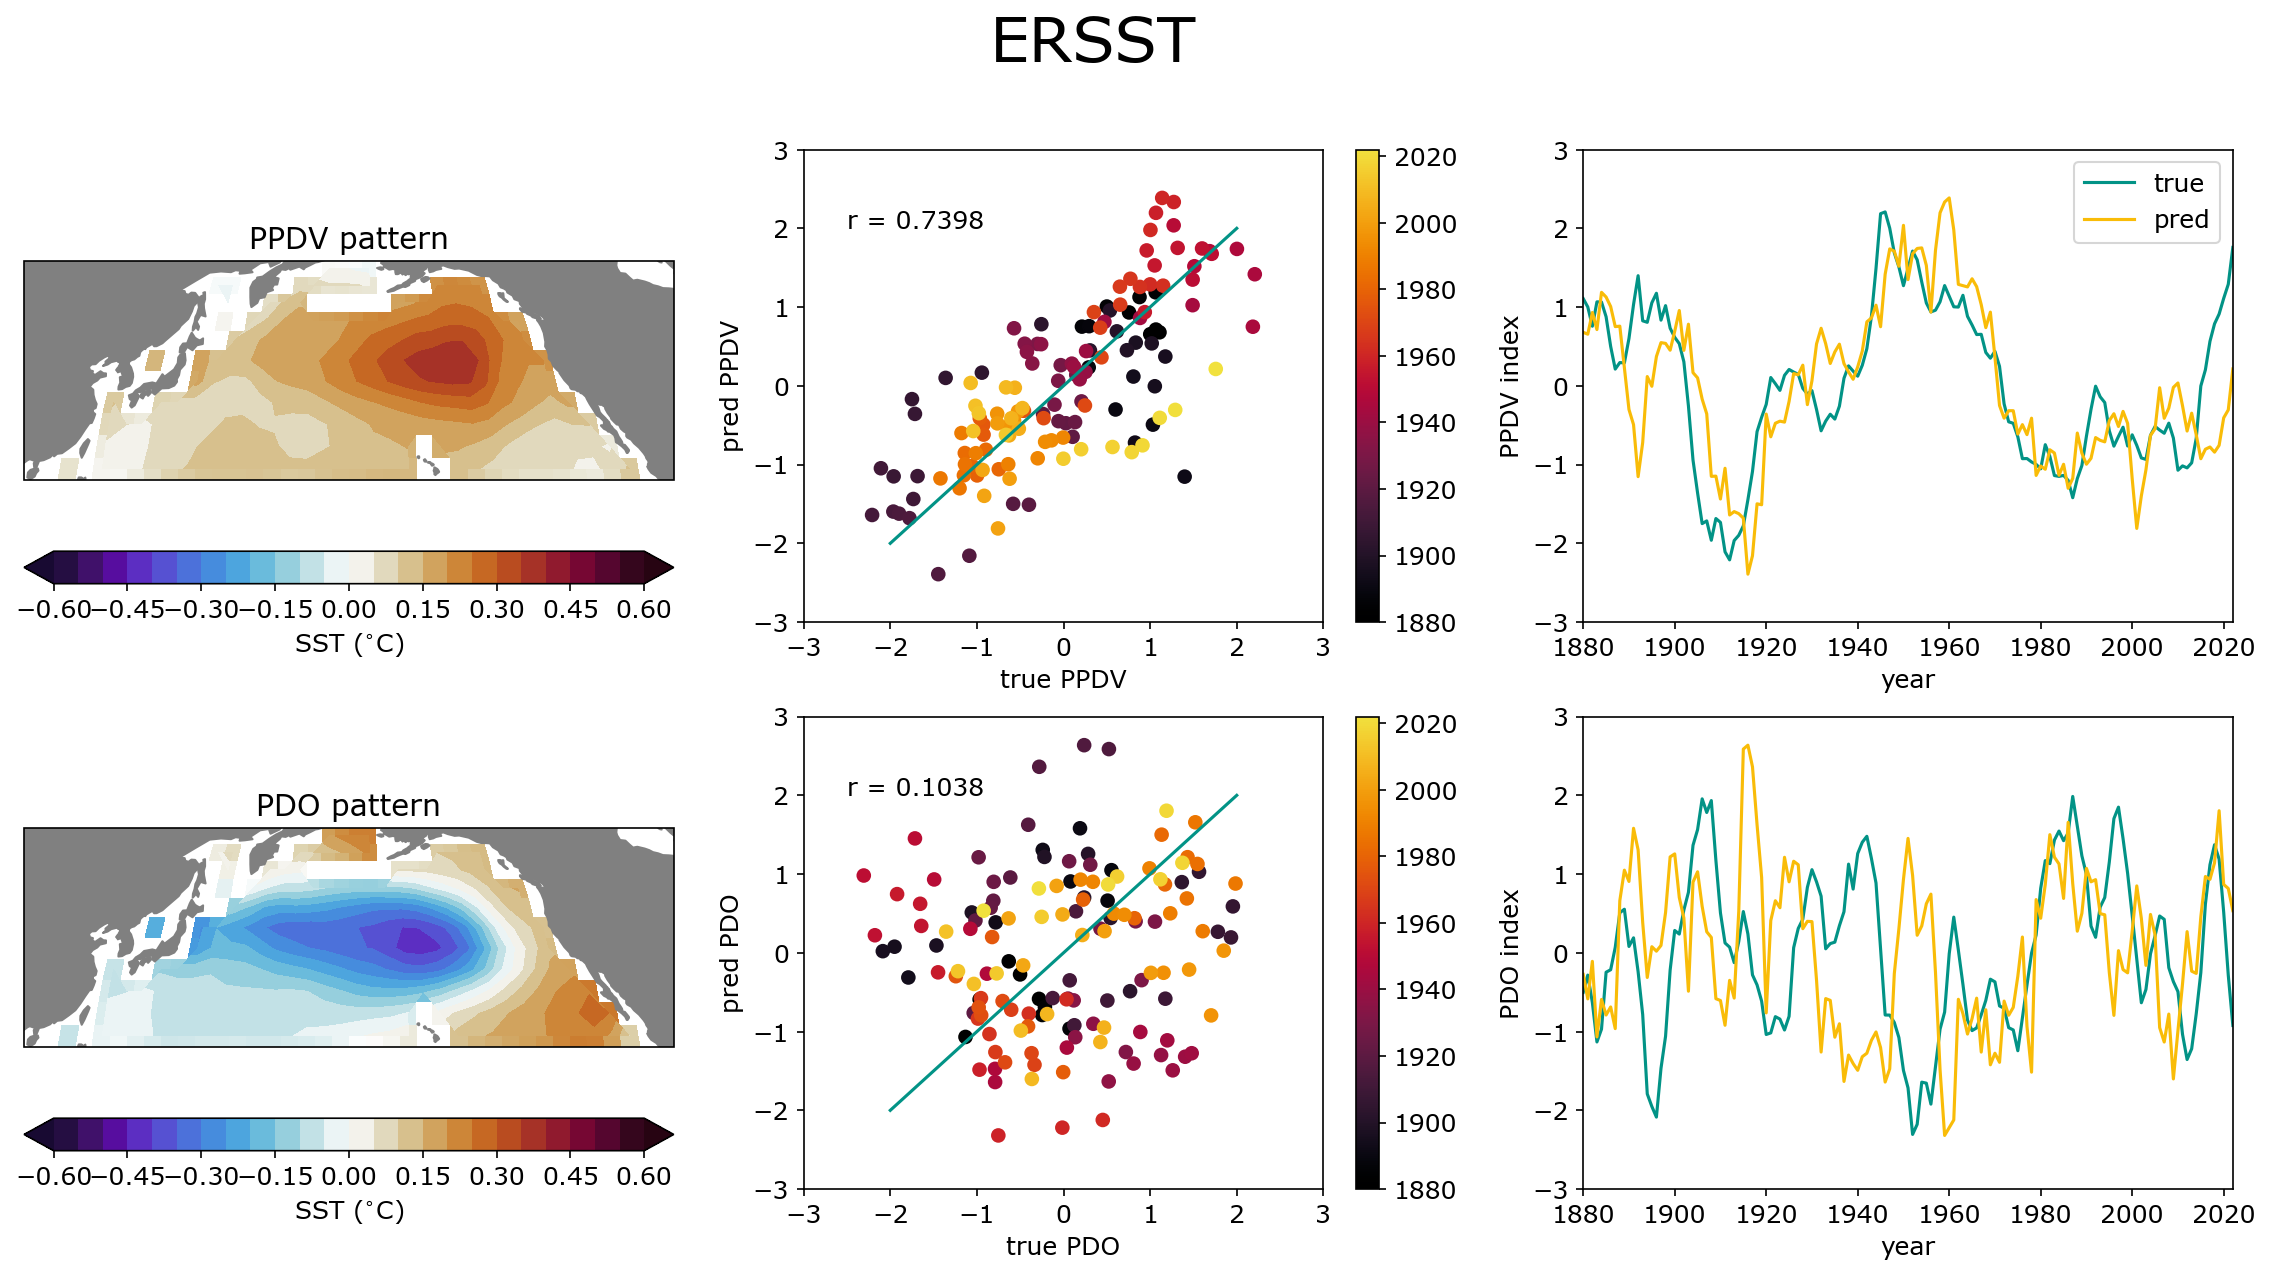

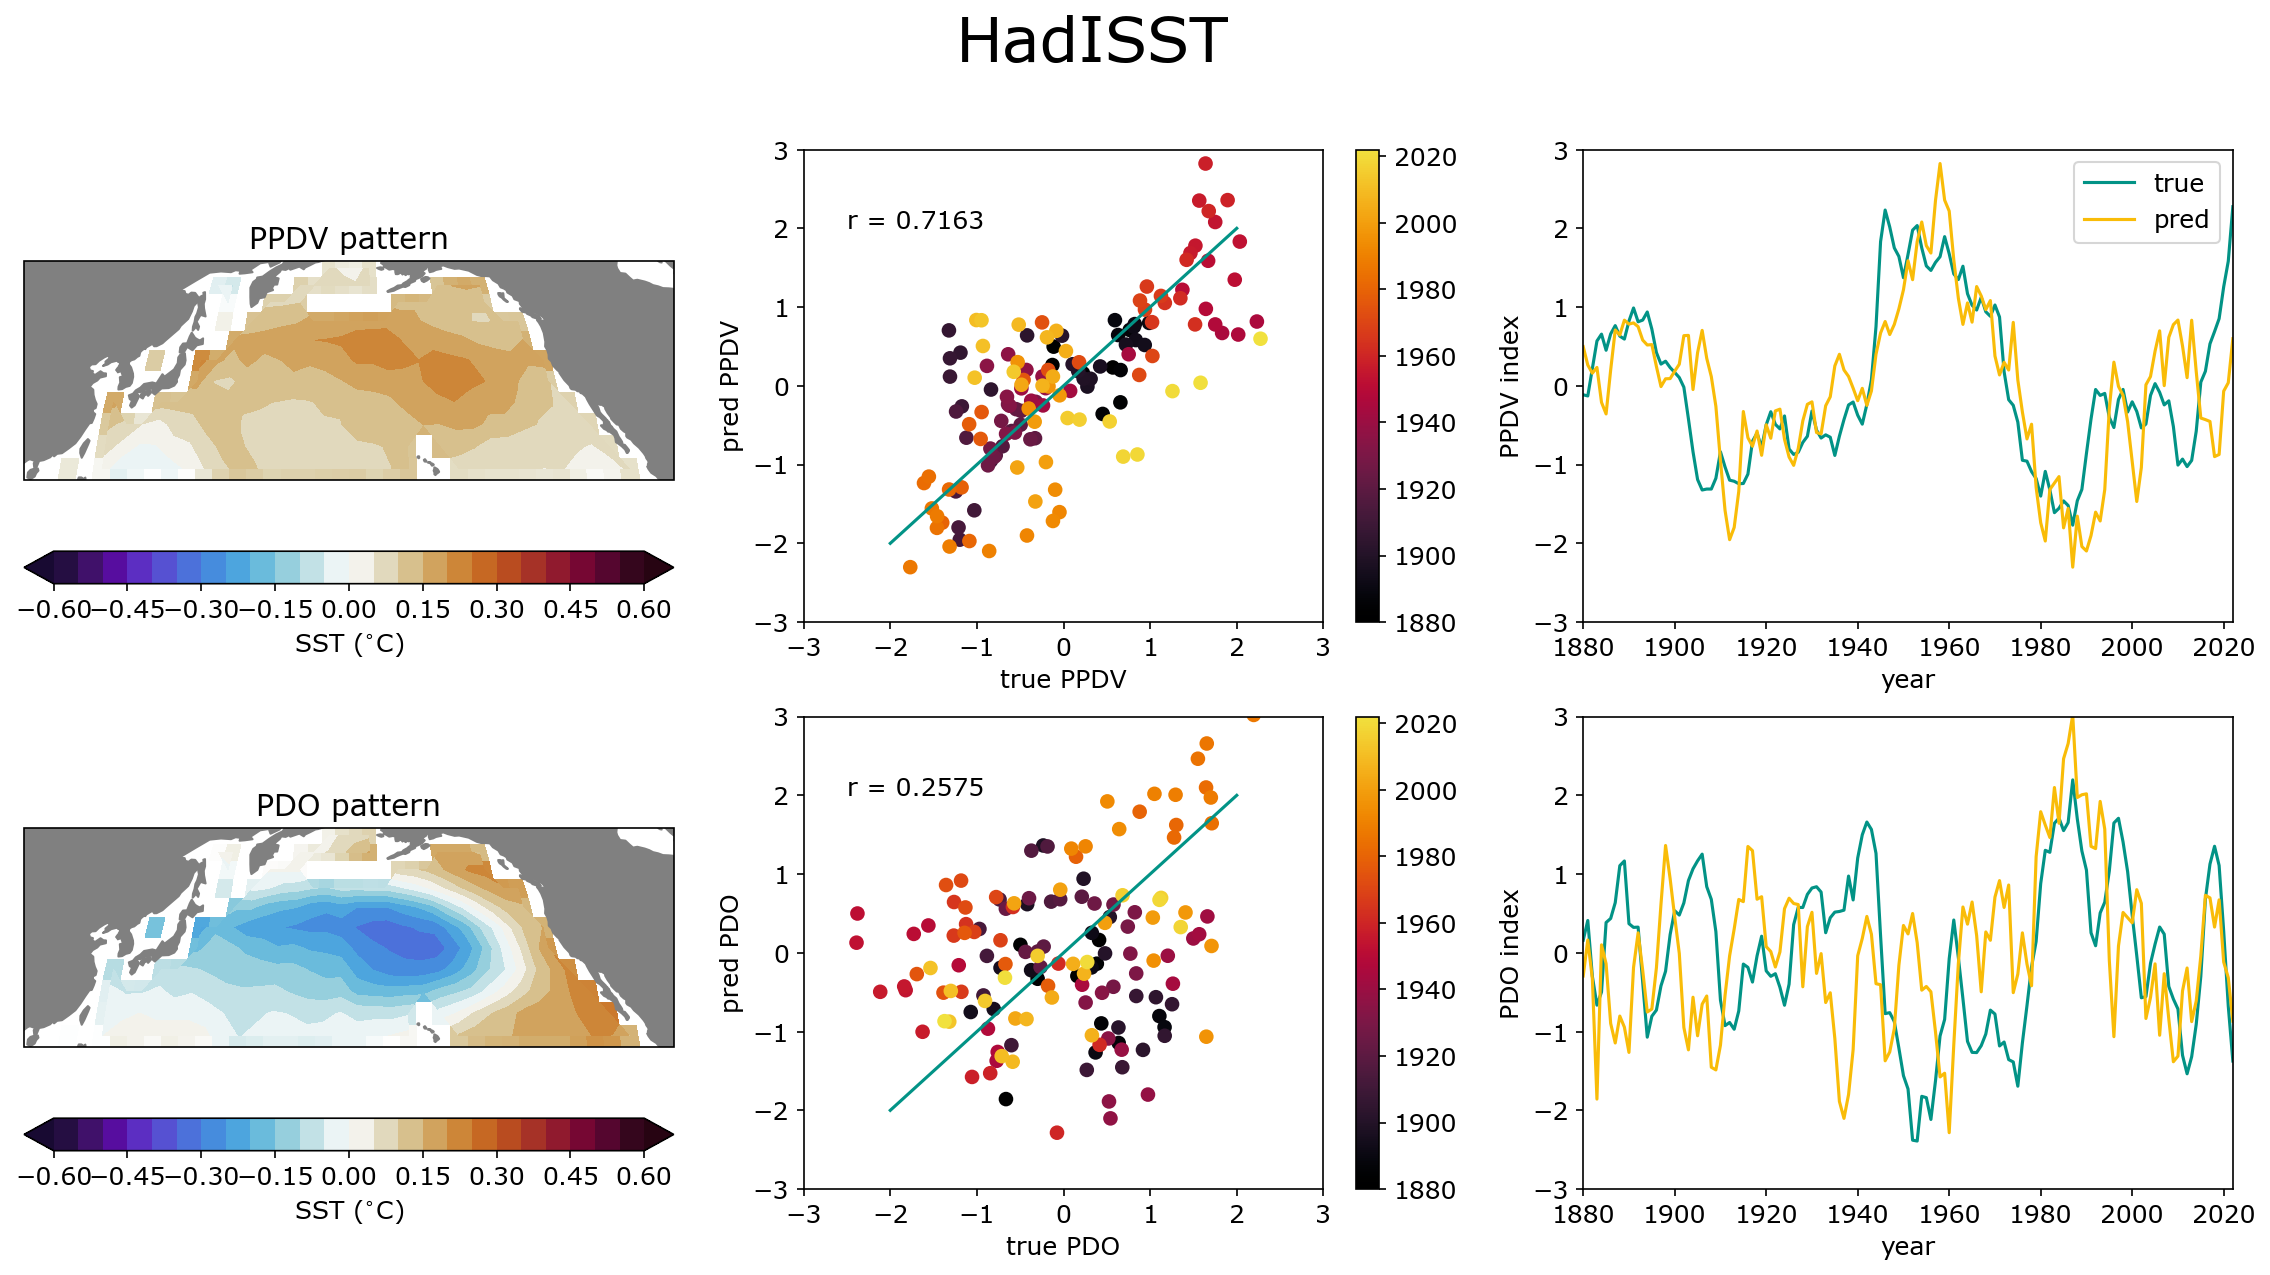

In [70]:
imp.reload(analysisplots)
y_pred_obs_ERSST = full_model.predict(inputobs_ERSST)
y_pred_obs_ERSST[:,np.sum(outputobs_ERSST,axis=0)==0]=0 # zero out land points

y_pred_obs_HadISST = full_model.predict(inputobs_HadISST)
y_pred_obs_HadISST[:,np.sum(outputobs_HadISST,axis=0)==0]=0 # zero out land points

obsPDO_ERSST = preprocessing.PDOobs(experiment_dict,"ERSST")
obsPDO_ERSST = np.asarray(obsPDO_ERSST)

obsPDO_HadISST = preprocessing.PDOobs(experiment_dict,"HadISST")
obsPDO_HadISST = np.asarray(obsPDO_HadISST)

analysisplots.patternplots_SST(bestpattern,obsPDO_ERSST,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,
                             landmask,lon,lat,obsyearvec,"ERSST",outputstd)

analysisplots.patternplots_SST(bestpattern,obsPDO_HadISST,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,
                             landmask,lon,lat,obsyearvec,"HadISST",outputstd)

for imodel,cmodel in enumerate(modellist):
         
    outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
    y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
    outputtest_singlemem = outputtestloop[:ntimesteps]
    y_pred_test_singlemem = y_pred_testloop[:ntimesteps]

    #analysisplots.patternplots_SST(bestpattern,PDOpatterns_singlemodel[imodel],outputtest_singlemem,y_pred_test_singlemem,outputval,y_pred_val,
     #                            landmask,lon,lat,modelyearvec,cmodel,outputstd)    

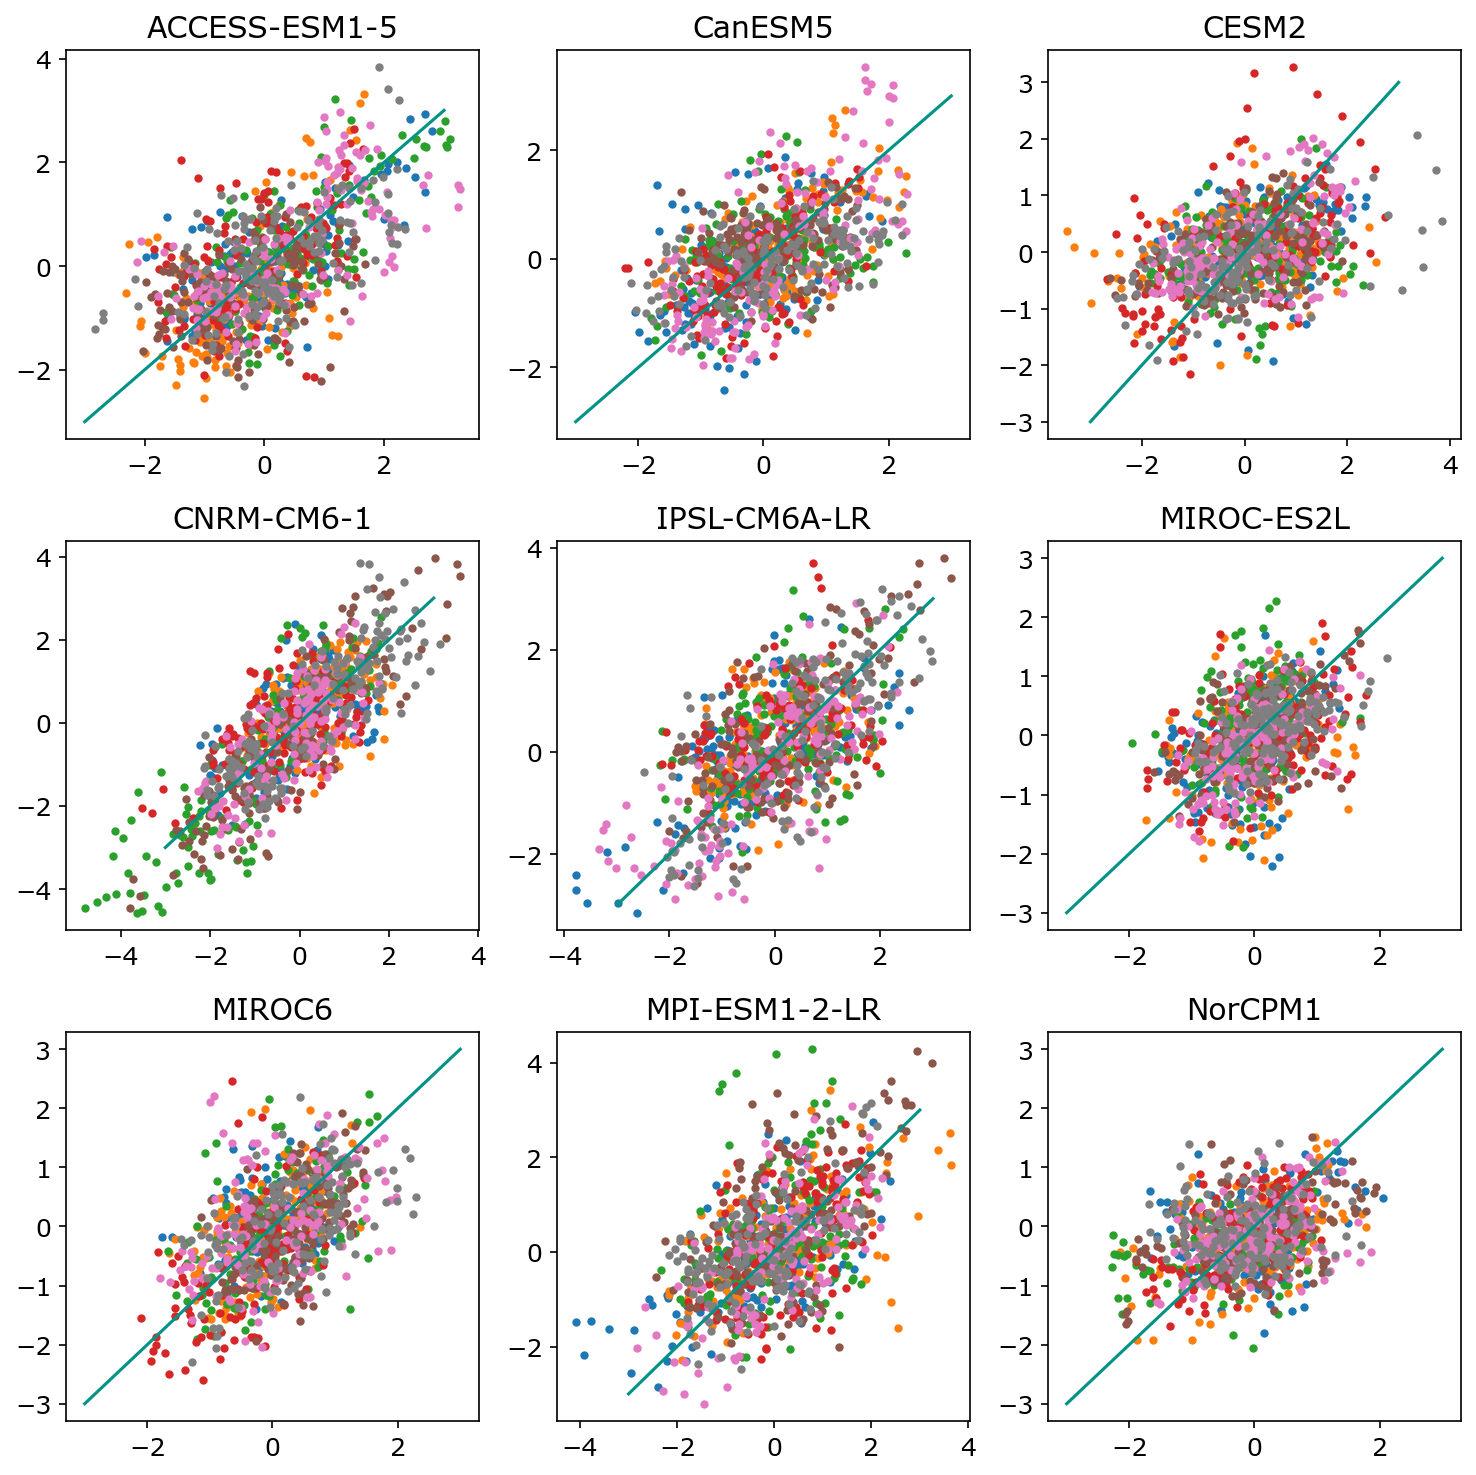

In [56]:
SCindex_model_true = allthelinalg.index_timeseries(outputtest,bestpattern,landmask)
SCindex_model_pred = allthelinalg.index_timeseries(y_pred_test,bestpattern,landmask)

plt.figure(figsize=(10,10))

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10(np.linspace(0,1,nmodels)))

for imodel,cmodel in enumerate(modellist):

    SCindex_model_true_loop = SCindex_model_true[imodel*n1model:(imodel+1)*n1model]
    SCindex_model_pred_loop = SCindex_model_pred[imodel*n1model:(imodel+1)*n1model]
    
    plt.subplot(3,3,imodel+1)
    for ivariant in range(nvariant):
        plt.scatter(SCindex_model_true_loop[ivariant*ntimesteps:(ivariant+1)*ntimesteps],
                    SCindex_model_pred_loop[ivariant*ntimesteps:(ivariant+1)*ntimesteps],marker='.')
    plt.title(cmodel)
    plt.plot(np.arange(-3,4),np.arange(-3,4),color='xkcd:teal')


plt.tight_layout()

1043

### Hmmmm it appears that we are doing well at predicting obs!

Let's find out just how well. Calculate the correlation coefficent between the SC index in truth and predictions for each individual testing ensemble member for each climate model and then also in the observations.

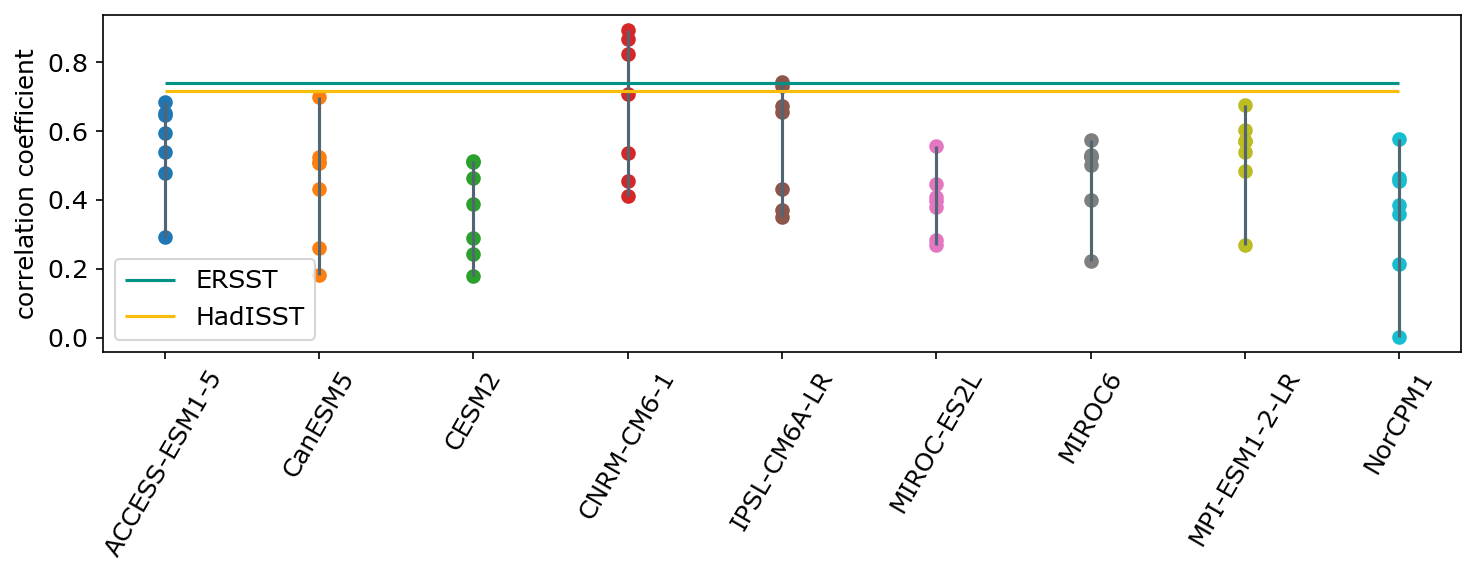

In [60]:
imp.reload(analysisplots)
modelpearsons = model_member_corr(bestpattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(
    bestpattern,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,landmask)

obscorrlist = [obspearson_ERSST,
              obspearson_HadISST]

obslabels = ["ERSST","HadISST"]

savestr = "figures/prettyscatterplot_fullmodel.png"
analysisplots.prettyscatterplot(modelpearsons,obscorrlist,modellist,testvariants,"correlation coefficient",obslabels,savestr)


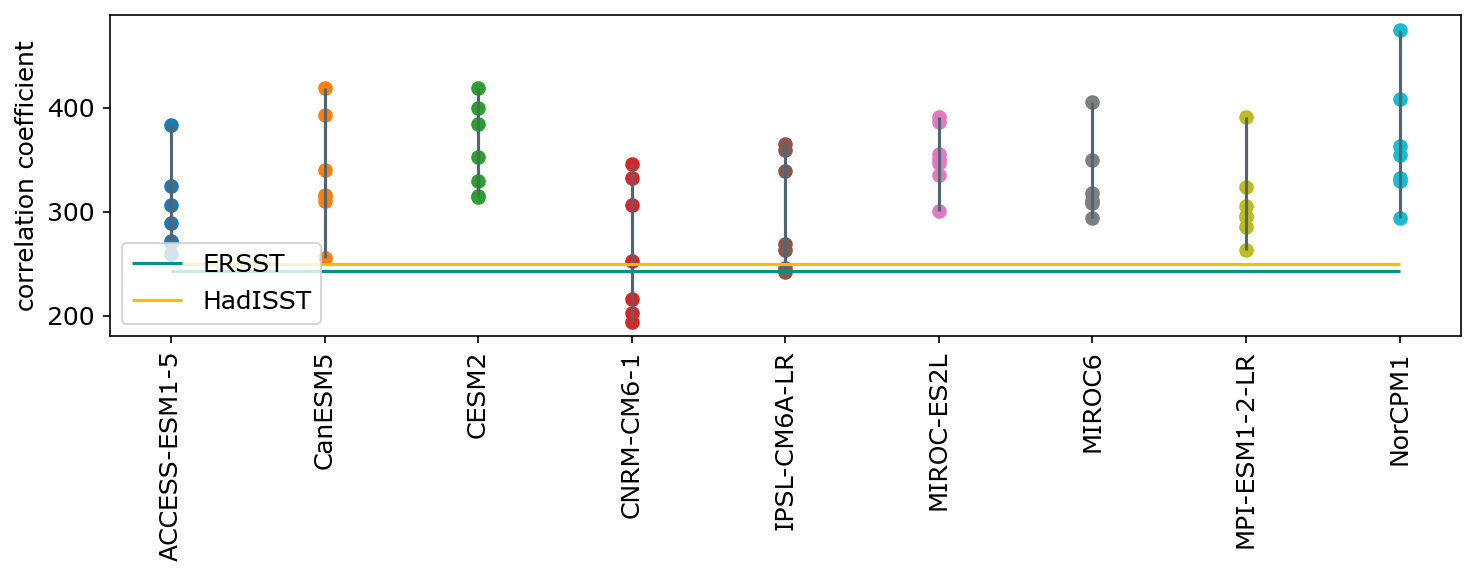

In [35]:
imp.reload(analysisplots)
imp.reload(allthelinalg)
modelerrs = model_member_err(bestpattern,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
obserr_ERSST = allthelinalg.err_indextimeseries(bestpattern,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,landmask)
obserr_HadISST = allthelinalg.err_indextimeseries(bestpattern,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,landmask)

obscorrlist = [obserr_ERSST,
              obserr_HadISST]

obslabels = ["ERSST","HadISST"]

#analysisplots.prettyscatterplot(modelerrs,obscorrlist,modellist,testvariants,"correlation coefficient",obslabels,"figures/interim.png")

### And compare that to how well we predict PDO

In [ ]:
modelpearsons = model_member_corr(PDOpattern_allmodel,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(obsPDO_ERSST,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(obsPDO_HadISST,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,landmask)

obscorrsPDOs = [obspearson_ERSST,obspearson_HadISST]

analysisplots.prettyscatterplot(modelpearsons,obscorrsPDOs,modellist,testvariants,"correlation coefficient",obslabels)

In [ ]:
modelpearsons = model_member_corr(PDOpatterns_singlemodel,outputtest,y_pred_test,outputval,y_pred_val,nmodels,nvariant,landmask)
obspearson_ERSST,obsps = allthelinalg.corr_indextimeseries(obsPDO_ERSST,outputobs_ERSST,y_pred_obs_ERSST,outputval,y_pred_val,landmask)
obspearson_HadISST,obsps = allthelinalg.corr_indextimeseries(obsPDO_HadISST,outputobs_HadISST,y_pred_obs_HadISST,outputval,y_pred_val,landmask)

obscorrsPDOs = [obspearson_ERSST,obspearson_HadISST]

analysisplots.prettyscatterplot(modelpearsons,obscorrsPDOs,modellist,testvariants,"correlation coefficient",obslabels)

### Project the index onto the input data to highlight how the patterns evolve

In [ ]:
imp.reload(analysisplots)
analysisplots.inputplots(inputobs_ERSST,y_pred_obs_ERSST,bestpattern,landmask,inres,"ERSST")
analysisplots.inputplots(inputobs_ERSST,outputobs_ERSST,bestpattern,landmask,inres,"ERSST")

In [ ]:
analysisplots.inputplots(inputobs_HadISST,outputobs_HadISST,bestpattern,landmask,inres,"HadISST")

### And each individual model just for fun

In [ ]:
for imodel,cmodel in enumerate(modellist):

    inputtestloop = reshapengrab(inputtest,imodel,nmodels,nvariant)
    outputtestloop = reshapengrab(outputtest,imodel,nmodels,nvariant)    
    y_pred_testloop = reshapengrab(y_pred_test,imodel,nmodels,nvariant)    
    
    analysisplots.inputplots(inputtestloop,outputtestloop,bestpattern,landmask,inres,cmodel)

### Variance explained by true pattern at each grid point in obs

In [ ]:
SCtimeseries_ERSST = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)
SCtimeseries_HadISST = allthelinalg.index_timeseries(outputobs_HadISST,bestpattern,landmask)

nlat = len(lat)
nlon = len(lon)

R_ERSST = np.empty((nlat,nlon))
R_HadISST = np.empty((nlat,nlon))

for ilat in range(nlat):
    for ilon in range(nlon):
        R_ERSST[ilat,ilon],_ = pearsonr(SCtimeseries_ERSST,outputobs_ERSST[:,ilat,ilon])
        R_HadISST[ilat,ilon],_ = pearsonr(SCtimeseries_HadISST,outputobs_HadISST[:,ilat,ilon])            


In [ ]:
plt.figure(figsize=(10,3))

a1=plt.subplot(1,2,1,projection=projection)
a1.pcolormesh(lon,lat,R_ERSST**2,vmin=0,vmax=0.7,cmap='inferno',transform=transform)
a1.coastlines(color='gray')

a2=plt.subplot(1,2,2,projection=projection)
c=a2.pcolormesh(lon,lat,R_HadISST**2,vmin=0,vmax=0.7,cmap='inferno',transform=transform)
a2.coastlines(color='gray')

cax=plt.axes((0.3,0.1,0.4,0.04))
cbar=plt.colorbar(c,cax=cax,orientation='horizontal')
cbar.ax.set_xlabel(r'R$^2$')

#plt.tight_layout()
plt.show()

In [ ]:
SCtimeseries = allthelinalg.index_timeseries(outputobs_ERSST,bestpattern,landmask)

optinput = np.empty((45,90,2))

for iplot in range(2):
    optinput[:,:,iplot] = np.mean(SCtimeseries[:,np.newaxis,np.newaxis]*inputobs_ERSST[:,:,:,iplot],axis=0)
    

In [ ]:
optoutput=full_model.predict(optinput[np.newaxis,:,:,:])

a=plt.subplot(1,1,1,projection=projection)
a.contourf(lon,lat,np.squeeze(optoutput),np.arange(-0.5,0.51,0.01),transform=transform,cmap=cmr.fusion_r)
a.coastlines(color='gray')